### Salient Differences from VAE Analysis

- **Presence of real victims drives anomalies**  
  - `victim_type_Missing`, `vict_descent_Missing`, `totalvictimcount_0` all have `normal_mean = 1.0` → `anomalous_mean = 0.0` (`abs_diff = 1.0`).  
  - Indicates that normal records often have **no victim info or zero victims**, while anomalies involve **actual victims with recorded demographics**.

- **Crimes involving actual persons are anomalous**  
  - `victim_type_Person` = 0.8 in anomalies.  
  - Normal crimes tend to be property-based or zero-victim; violent/personal crimes stand out.

- **Multiple victims or multiple offenses contribute to anomaly**  
  - `totalvictimcount_2` and `totaloffensecount_2` show elevated values (`abs_diff = 0.35–0.45`).  
  - Normal crimes usually involve a single victim and a single offense.

- **Weapon usage differs from the norm**   
  - `weapon_desc_Missing` is more common in anomalous records (`abs_diff = 0.55`), reflecting irregular patterns in weapon reporting.

- **Case status is a distinguishing factor**  
  - `status_desc_Cleared by Arrest` is anomalous (`abs_diff = 0.55`) versus normal cases that are mostly “Investigation Continued.”

- **Victim demographics mark anomalies**  
  - `vict_sex_F` and `vict_sex_Other` have elevated anomalous means (`abs_diff = 0.40–0.55`).  
  - `vict_descent_Other` also stands out (`abs_diff = 0.45`).  
  - Suggests that victims outside the typical demographic profile contribute to anomalous records.

- **Crime type and location contribute moderately**  
  - `crime_against_Society` and `premis_desc_Street/Parkway` show moderate deviations (`abs_diff ≈ 0.65`).  
  - Rarely occurring crime types or unusual locations contribute to the anomaly signal.

- **Special circumstances highlight rare events**  
  - `homeless_arrestee_crime` = 0.40 → involvement of homeless individuals is uncommon.

---

**Overall takeaway:**  
- Anomalous records are characterized by **actual victims, unusual victim demographics, multiple victims or offenses, weapons, or special circumstances**.  
- These records **break the pattern of routine, single-victim, property-focused crimes** and correspond to higher-impact or socially salient incidents.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from vae_anomaly_detection import (
    load_and_prepare_data,
    CrimeDataset,
    VAE,
    train_vae,
    get_reconstruction_errors,
    detect_anomalies,
    per_feature_errors
)

plt.rcParams.update({"figure.dpi": 140})
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cpu


In [2]:
DATA_PATH = "lapd_offenses_victims_features.pkl"

train_df, test_df, encoders, feature_names = load_and_prepare_data(
    DATA_PATH,
    test_size=0.20
)

In [3]:
# -------- DATALOADERS --------
train_loader = DataLoader(CrimeDataset(train_df), batch_size=128, shuffle=True)
test_loader  = DataLoader(CrimeDataset(test_df),  batch_size=128, shuffle=False)

In [4]:
from scipy.spatial.distance import cdist

# ----------------------------------------------------
# Objective function: Quantitative validation
# ----------------------------------------------------
def vae_objective_score(model, train_loader, test_loader, device="cpu", recon_percentile=99.0):
    """
    Computes a score for the trained VAE:
    1. Low reconstruction error for normal training data
    2. High anomaly-normal separation in latent space
    Returns a single scalar score to maximize
    """
    # Step A: Train reconstruction error
    train_errors, _ = get_reconstruction_errors(model, train_loader, device=device)
    mean_train_err = np.mean(train_errors)

    # Step B: Test set reconstruction errors + anomaly detection
    test_errors, test_z = get_reconstruction_errors(model, test_loader, device=device)
    is_anom, _ = detect_anomalies(test_errors, recon_percentile=recon_percentile)

    # Step C: Latent-space separation
    normal_z = test_z[~is_anom]
    anom_z   = test_z[is_anom]

    if len(anom_z) > 0 and len(normal_z) > 0:
        dist_matrix = cdist(anom_z, normal_z)
        mean_latent_dist = dist_matrix.mean()
    else:
        mean_latent_dist = 0.0

    # --- Combine metrics into a single score ---
    # Maximize latent separation, penalize high train reconstruction error
    # You can adjust weights if desired
    score = mean_latent_dist - 0.5 * mean_train_err
    return score, mean_train_err, mean_latent_dist, is_anom.sum()

# ----------------------------------------------------
# Hyperparameter search
# ----------------------------------------------------
LATENT_DIMS = [4, 8, 16, 32]
BETAS = [0.7, 1.0, 1.5]
EPOCHS = 70
RECON_PERCENTILE = 99.0

results = []

best_score = -np.inf
best_params = None
best_model = None
best_anomalies = None

for L in LATENT_DIMS:
    for B in BETAS:
        print(f"\n=== Testing latent_dim={L}, beta={B} ===")
        model = VAE(input_dim=train_df.shape[1], hidden_dims=[256,128,64], latent_dim=L).to(DEVICE)

        # Train
        _ = train_vae(model, train_loader, epochs=EPOCHS, lr=1e-3, beta=B, device=DEVICE)

        # Evaluate quantitative score
        score, mean_train_err, mean_latent_dist, num_anom = vae_objective_score(
            model, train_loader, test_loader, device=DEVICE, recon_percentile=RECON_PERCENTILE
        )

        results.append({
            "latent_dim": L,
            "beta": B,
            "score": score,
            "train_err": mean_train_err,
            "mean_latent_dist": mean_latent_dist,
            "num_anomalies": num_anom
        })

        print(f"Score: {score:.4f} | Train Err: {mean_train_err:.4f} | Latent Separation: {mean_latent_dist:.4f} | Detected anomalies: {num_anom}")

        # Track best
        if score > best_score:
            best_score = score
            best_params = {"latent_dim": L, "beta": B}
            best_model = model
            best_anomalies = num_anom

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values("score", ascending=False, inplace=True)

print("\n=== Hyperparameter search complete ===")
print("Best hyperparameters:", best_params)
print("Best score:", best_score)
print("Best model detected anomalies:", best_anomalies)



=== Testing latent_dim=4, beta=0.7 ===
Epoch 0/70 - Avg loss: 9.120150
Epoch 10/70 - Avg loss: 8.372653
Epoch 20/70 - Avg loss: 8.345451
Epoch 30/70 - Avg loss: 8.337201
Epoch 40/70 - Avg loss: 8.332428
Epoch 50/70 - Avg loss: 8.326618
Epoch 60/70 - Avg loss: 8.326392
Score: 1.5525 | Train Err: 0.0539 | Latent Separation: 1.5795 | Detected anomalies: 437

=== Testing latent_dim=4, beta=1.0 ===
Epoch 0/70 - Avg loss: 9.258659
Epoch 10/70 - Avg loss: 8.738800
Epoch 20/70 - Avg loss: 8.733011
Epoch 30/70 - Avg loss: 8.733482
Epoch 40/70 - Avg loss: 8.731931
Epoch 50/70 - Avg loss: 8.725688
Epoch 60/70 - Avg loss: 8.727131
Score: 0.8137 | Train Err: 0.0599 | Latent Separation: 0.8437 | Detected anomalies: 437

=== Testing latent_dim=4, beta=1.5 ===
Epoch 0/70 - Avg loss: 9.461049
Epoch 10/70 - Avg loss: 9.108308
Epoch 20/70 - Avg loss: 9.101389
Epoch 30/70 - Avg loss: 9.103749
Epoch 40/70 - Avg loss: 9.100708
Epoch 50/70 - Avg loss: 9.097211
Epoch 60/70 - Avg loss: 9.097119
Score: 0.8062 

In [5]:
model = VAE(input_dim=train_df.shape[1], hidden_dims=[256,128,64], latent_dim=best_params["latent_dim"]) # 
losses = train_vae(
    model,
    train_loader,
    epochs=EPOCHS,
    lr=1e-3,
    beta=best_params["beta"], # 
    device=DEVICE
)

Epoch 0/70 - Avg loss: 9.323045
Epoch 10/70 - Avg loss: 8.400597
Epoch 20/70 - Avg loss: 8.385399
Epoch 30/70 - Avg loss: 8.372221
Epoch 40/70 - Avg loss: 8.368321
Epoch 50/70 - Avg loss: 8.335964
Epoch 60/70 - Avg loss: 8.326468


In [25]:
best_params

{'latent_dim': 16, 'beta': 0.7}

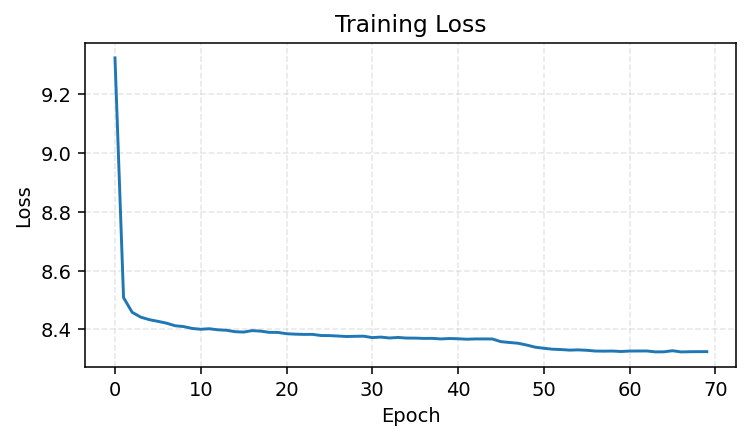

In [6]:
plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

In [21]:
# per-feature reconstruction error: High mean reconstruction error for a feature → that feature is unusual / poorly reconstructed → possible anomaly.
feature_err_df, originals_df, recons_df = per_feature_errors(model, test_loader, feature_names, device=DEVICE)

# Example: mean error per feature
mean_feature_error = feature_err_df.mean().to_frame(name="recon_error")
mean_feature_error.sort_values(by="recon_error", ascending=False, inplace=True)
mean_feature_error.head(20)

,recon_error
is_weekend,0.210038
vict_descent_Hispanic,0.198813
vict_age_30-45,0.189274
nibr_description_Other,0.188666
premis_desc_Other,0.177719
status_desc_Investigation Continued,0.172168
premis_desc_Street/Parkway,0.157774
vict_age_18-30,0.152672
vict_age_45-60,0.139238
status_desc_Cleared by Arrest,0.136090


In [8]:
# Compute total anomaly score per sample
sample_scores = feature_err_df.sum(axis=1)  # total MSE per sample
is_anom, threshold = detect_anomalies(sample_scores, recon_percentile=99.0)

In [34]:
# Identify most anomalous features per sample
anom_idx = np.where(is_anom)[0][0]  # first anomalous sample
anom_feature_errors = feature_err_df.iloc[anom_idx].to_frame(name="recon_error")
anom_feature_errors.sort_values(by="recon_error",ascending=False, inplace=True)
anom_feature_errors

,recon_error
nibr_description_594(B)(1) - PC - F - Vandalism ($400 Or More) - Felony - 290,9.854942e-01
month_1,8.999941e-01
area_name_Rampart,8.850139e-01
crime_against_Property,8.759270e-01
homeless_suspect_crime,8.727794e-01
...,...
victim_type_Society (Public),9.530721e-15
totalvictimcount_0,3.460882e-15
victim_type_Missing,2.957203e-15
victim_type_Business,1.869542e-16


In [35]:
# inspect most anomalous features per sample
orig_row = originals_df.iloc[anom_idx]
recon_row = recons_df.iloc[anom_idx]
# Combine into a single comparison DataFrame
comparison = pd.DataFrame({
    "original": orig_row,
    "reconstructed": recon_row,
    "error": feature_err_df.iloc[anom_idx]
})
# Show the top features for this anomaly
comparison.sort_values(by="error", ascending=False).head(20)

,original,reconstructed,error
nibr_description_594(B)(1) - PC - F - Vandalism ($400 Or More) - Felony - 290,1.0,0.007279,0.985494
month_1,1.0,0.051320,0.899994
area_name_Rampart,1.0,0.059248,0.885014
crime_against_Property,1.0,0.064090,0.875927
homeless_suspect_crime,1.0,0.065773,0.872779
crime_against_Person,0.0,0.922767,0.851500
premis_desc_Victim's Residence,1.0,0.081459,0.843717
vict_descent_White/Caucasian,1.0,0.087639,0.832403
vict_age_45-60,1.0,0.145240,0.730614
totaloffensecount_2,1.0,0.232965,0.588343


In [38]:
# Inspect “normal” representative examples
normal_idx = sample_scores.argmin()
orig_row = originals_df.iloc[normal_idx]
recon_row = recons_df.iloc[normal_idx]
# Combine into a single comparison DataFrame
comparison = pd.DataFrame({
    "original": orig_row,
    "reconstructed": recon_row,
    "error": feature_err_df.iloc[normal_idx]
})
# Show the top features for this anomaly
comparison.sort_values(by="error", ascending=False).head(20)

,original,reconstructed,error
month_7,1.0,0.063591,0.876862
area_name_77th Street,1.0,0.176448,0.678239
gang_related_crime,1.0,0.353514,0.417944
premis_desc_Street/Parkway,1.0,0.536882,0.214478
is_weekend,0.0,0.360824,0.130194
status_desc_Investigation Continued,1.0,0.684935,0.099266
status_desc_Cleared by Arrest,0.0,0.276928,0.076689
area_name_Newton,0.0,0.167078,0.027915
weapon_desc_Other,0.0,0.161432,0.026060
premis_desc_Other,0.0,0.132404,0.017531


In [40]:
# Top 20 anomalies (highest total reconstruction error) Vs Top 20 normal samples (lowest total reconstruction error)
top_anom_idx = sample_scores.sort_values(ascending=False).head(20).index
top_normal_idx = sample_scores.sort_values(ascending=True).head(20).index

anom_originals = originals_df.iloc[top_anom_idx]
normal_originals = originals_df.iloc[top_normal_idx]

anom_means = anom_originals.mean(axis=0).to_frame(name="anomalous_mean")
normal_means = normal_originals.mean(axis=0).to_frame(name="normal_mean")

comparison_df = pd.concat([normal_means, anom_means], axis=1)
comparison_df["difference"] = comparison_df["anomalous_mean"] - comparison_df["normal_mean"]

# Sort by absolute difference (largest change first)
comparison_df["abs_diff"] = comparison_df["difference"].abs()
comparison_df_sorted = comparison_df.sort_values(by="abs_diff", ascending=False)

# Display top 20 largest feature differences
comparison_df_sorted.head(20)

,normal_mean,anomalous_mean,difference,abs_diff
victim_type_Missing,1.0,0.00,-1.00,1.00
vict_descent_Missing,1.0,0.00,-1.00,1.00
totalvictimcount_0,1.0,0.00,-1.00,1.00
weapon_desc_Handgun,1.0,0.05,-0.95,0.95
totaloffensecount_1,1.0,0.20,-0.80,0.80
victim_type_Person,0.0,0.80,0.80,0.80
status_desc_Investigation Continued,1.0,0.25,-0.75,0.75
vict_age_Missing,1.0,0.35,-0.65,0.65
premis_desc_Street/Parkway,1.0,0.35,-0.65,0.65
crime_against_Society,1.0,0.35,-0.65,0.65
